# Plot Heatmap for BA, COVID, Flu, HIV, MRSA,OP

## Method
PyComplexHeatmap (https://github.com/DingWB/PyComplexHeatmap) was employed to to plot the complex heatmaps. For better visualization, we only labeled the hypomethylated DMRs in the corresponding sample groups and cell types. Rows in the heatmap were split according to the sample groups, and columns were split according to the DMR groups and cell types. Within each row and columns subgroup, the rows and columns were then clustered with ward linkage and the jaccard metric.

In [ ]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi']=300
sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap"))
import seaborn as sns
from PyComplexHeatmap import *
from matplotlib.colors import LinearSegmentedColormap
set_default_style()

In [ ]:
def plot_heatmap(title="COVID",sample_label_dict=None,ct_mapping=None,delta_beta_cutoff=None,
                ct_color_dict=None,sample_group_color_dict=None,row_split_order=None,sep='\t'):
    data=pd.read_csv(f"../data/{title}_DMRs.tsv",sep=sep)
    def assign_group_for_na(hypo,hyper,groups):
        if pd.isna(hypo) and pd.isna(hyper):
            return np.nan
        if not pd.isna(hypo):
            if ',' not in hypo:
                return hypo
            else:
                return ','.join(sorted([sample_label_dict[g] for g in str(hypo).strip().split(',') if g!=hyper]))
        group1=sorted([sample_label_dict[g] for g in groups if g not in str(hyper).split(',')])
        return ','.join(group1)
            
    data.hypomethylated_samples=data.loc[:,['hypomethylated_samples','hypermethylated_samples']]\
    .apply(lambda x:assign_group_for_na(x[0],x[1],list(sample_label_dict.keys())),axis=1)
    data.dropna(subset=['hypomethylated_samples'],inplace=True)

    if type(sample_label_dict)==list:
        sample_cols=sample_label_dict
    else:# dict
        data.rename(columns=sample_label_dict,inplace=True)
        sample_cols=[sample_label_dict[col] for col in sample_label_dict.keys()]
        data.hypomethylated_samples.replace(sample_label_dict,inplace=True)
        # data.hypomethylated_samples.fillna('Multi',inplace=True)
        other_groups=[g for g in data.hypomethylated_samples.unique().tolist() if g not in sample_cols+['NA']]
        print(other_groups)
        colors = sns.color_palette("tab20")
        for i,g in enumerate(other_groups):
            sample_group_color_dict[g]=colors[i]
        
    if not ct_mapping is None:
        data.celltype.replace(ct_mapping,inplace=True)
        
    if not delta_beta_cutoff is None:
        delta_beta=data.loc[:,sample_cols].apply(lambda x:x.max()-x.min(),axis=1).abs()
        data=data.loc[delta_beta>=delta_beta_cutoff]
    
    df_cols=data.loc[:,['#chr','start','end','celltype','hypomethylated_samples']+sample_cols]
    keep_cols=[col for col in data.columns if '_' in col and col.split('_')[0] in sample_label_dict.keys()]
    data=data.loc[:,['#chr','start','end','celltype']+keep_cols]
    print(data.shape)
    print(data.head())
    print(df_cols.head())
    df_cols['CellType']=df_cols.celltype
    df_cols.set_index(['#chr','start','end','celltype'],inplace=True)
    data.set_index(['#chr','start','end','celltype'],inplace=True)
    df_rows=data.columns.to_frame()
    df_rows['Group']=df_rows.index.to_series().apply(lambda x:x.split('_')[0])
    df_rows.Group.replace(sample_label_dict,inplace=True)
    
    print(df_cols.hypomethylated_samples.unique())

    row_ha = HeatmapAnnotation(Group=anno_simple(df_rows.Group,colors=sample_group_color_dict,legend=False,
                                                 height=5,add_text=True,text_kws={'color':'white','fontsize':12,'fontweight':'bold'}),
                               axis=0,verbose=0) #label_kws={'visible':False}
    
    col_ha_dict={
                # 'label':anno_label(df_cols.CellType,merge=True,rotation=45,extend=False,
                #                                 colors=ct_color_dict,adjust_color=True,luminance=0.75), #fontsize=10,relpos=(0.5,0)
                'Group':anno_simple(df_cols.hypomethylated_samples,colors=sample_group_color_dict,legend=True),
                'CellType':anno_simple(df_cols.CellType,colors=ct_color_dict,legend=True)
                }
    # i=0
    # for col in sample_cols:
    #     if i==0:
    #         lgd=True
    #     else:
    #         lgd=False
    #     col_ha_dict[col]=anno_simple(df_cols[col],cmap='jet',legend=lgd,vmax=1,vmin=0,legend_kws={'label':'Mean'})
    #     i+=1

    col_ha = HeatmapAnnotation(**col_ha_dict,
                               verbose=0,label_side='right',label_kws={'horizontalalignment':'left'})

    plt.figure(figsize=(14, 6))
    cm = ClusterMapPlotter(data=data.T, top_annotation=col_ha, left_annotation=row_ha,
                           row_cluster_method='ward', row_cluster_metric='jaccard',
                           col_cluster_method='ward', col_cluster_metric='jaccard',
                           col_split=df_cols.loc[:,['hypomethylated_samples','CellType']], col_split_gap=0,
                           row_split=df_rows.Group, row_split_gap=0.4,row_split_order=row_split_order,
                           label='beta',show_rownames=False,show_colnames=False,
                           legend_gap=5,legend_width=30,legend_hpad=0,legend_vpad=3,
                           cmap='parula',rasterized=True)
    plt.savefig(os.path.expanduser(f"~/Gallery/20230514_{title}.pdf"), bbox_inches='tight')
    plt.show()

['S,nS', 'Ctrl,nS', 'Ctrl,S']
(203809, 63)
   #chr    start      end celltype  C_Cov2_1  C_Cov2_12  C_Cov2_13  C_Cov2_17  \
0  chr1   775204   775204    B-Mem       0.0        0.0        NaN        NaN   
1  chr1   939607   939607    B-Mem       0.0        0.0        NaN        NaN   
2  chr1   943937   943937    B-Mem       1.0        NaN        1.0        1.0   
3  chr1  1054900  1054901    B-Mem       0.0        NaN        0.0        0.0   
4  chr1  1060771  1060771    B-Mem       1.0        1.0        1.0        NaN   

   C_Cov2_18  C_Cov2_19  ...  Ctrl_HIV_10  Ctrl_HIV_13  Ctrl_HIV_16  \
0        NaN        0.0  ...          NaN          NaN          1.0   
1        NaN        NaN  ...          1.0         0.75          1.0   
2        NaN        1.0  ...          1.0         1.00          1.0   
3        NaN        NaN  ...          0.5         0.00          0.0   
4        1.0        NaN  ...          1.0         1.00          1.0   

   Ctrl_HIV_19  Ctrl_HIV_22  Ctrl_HIV_25  C

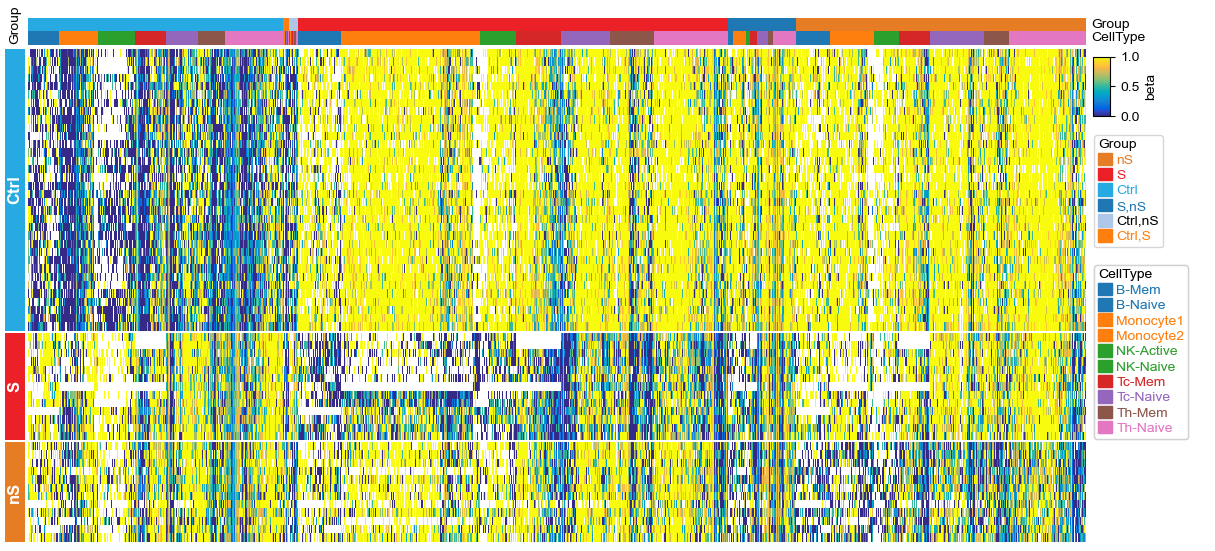

In [ ]:
delta_beta_cutoff=None
color_plate = sns.color_palette("tab10")
ct_color_dict = {'B-Mem': color_plate[0],
             'B-Naive': color_plate[0],
             'Monocyte1': color_plate[1],
             'Monocyte2': color_plate[1],
             'NK-Active': color_plate[2],
             'NK-Naive': color_plate[2],
             'Tc-Mem': color_plate[3],
             'Tc-Naive': color_plate[4],
             'Th-Mem': color_plate[5],
             'Th-Naive': color_plate[6]}

plot_heatmap(title="COVID",sample_label_dict={'C':'nS','Ctrl':'Ctrl','W':'S'},
            ct_mapping={'NK-cell1':'NK-Active','NK-cell2': 'NK-Naive','Monocyte':'Monocyte1','Monocyte1':'Monocyte2'},
            ct_color_dict=ct_color_dict,delta_beta_cutoff=delta_beta_cutoff,
            sample_group_color_dict={'nS':'#E67D25','S':'#EC2027','Ctrl':'#27AAE1'},
            row_split_order=['Ctrl','S','nS'])

In [ ]:
# sample_label_dict={'unfrequent':'Infreq','Ctrl':'Ctrl','frequent':'Freq'}
# ct_mapping={'NK-cell1':'NK-Active','NK-cell2': 'NK-Naive','Monocyte':'Monocyte1','Monocyte1':'Monocyte2'}
# sample_group_color_dict={'Infreq':'#E67D25','Freq':'#EC2027','Ctrl':'#27AAE1'}

# plot_heatmap(title="BA",sample_label_dict=sample_label_dict,delta_beta_cutoff=delta_beta_cutoff,
#             ct_mapping=ct_mapping,ct_color_dict=ct_color_dict,
#             sample_group_color_dict=sample_group_color_dict)

In [ ]:
# sample_label_dict={'D1':'Pre','D28':'Post'}
# ct_mapping={'NK-cell1':'NK-Active','NK-cell2': 'NK-Naive','Monocyte':'Monocyte1','Monocyte1':'Monocyte2'}
# sample_group_color_dict={'Pre':'#E67D25','Post':'#EC2027'}

# plot_heatmap(title="Flu",sample_label_dict=sample_label_dict,delta_beta_cutoff=delta_beta_cutoff,
#             ct_mapping=ct_mapping,ct_color_dict=ct_color_dict,
#             sample_group_color_dict=sample_group_color_dict)

['Acute,Chronic', 'Chronic,Ctrl', 'Acute,Ctrl']
(104421, 31)
   #chr   start     end celltype  pre_HIV_1  pre_HIV_10  pre_HIV_13  \
1  chr1  634024  634028    B-Mem   0.253125    0.196809    0.216749   
2  chr1  901492  901492    B-Mem   0.000000         NaN    0.500000   
3  chr1  921752  921752    B-Mem   1.000000    1.000000    0.666667   
4  chr1  971617  971617    B-Mem   1.000000    0.000000         NaN   
5  chr1  981483  981483    B-Mem   0.333333    1.000000    0.500000   

   pre_HIV_16  pre_HIV_19  pre_HIV_22  ...  acu_HIV_8  cro_HIV_12  cro_HIV_15  \
1    0.265517       0.276    0.315152  ...   0.196721    0.184915    0.096296   
2    0.333333         NaN    0.666667  ...   1.000000    1.000000    1.000000   
3    1.000000         NaN    1.000000  ...        NaN    1.000000         NaN   
4         NaN       1.000    1.000000  ...   1.000000    0.000000         NaN   
5    0.333333       0.500    0.000000  ...   1.000000    1.000000         NaN   

   cro_HIV_18  cro_HIV_21

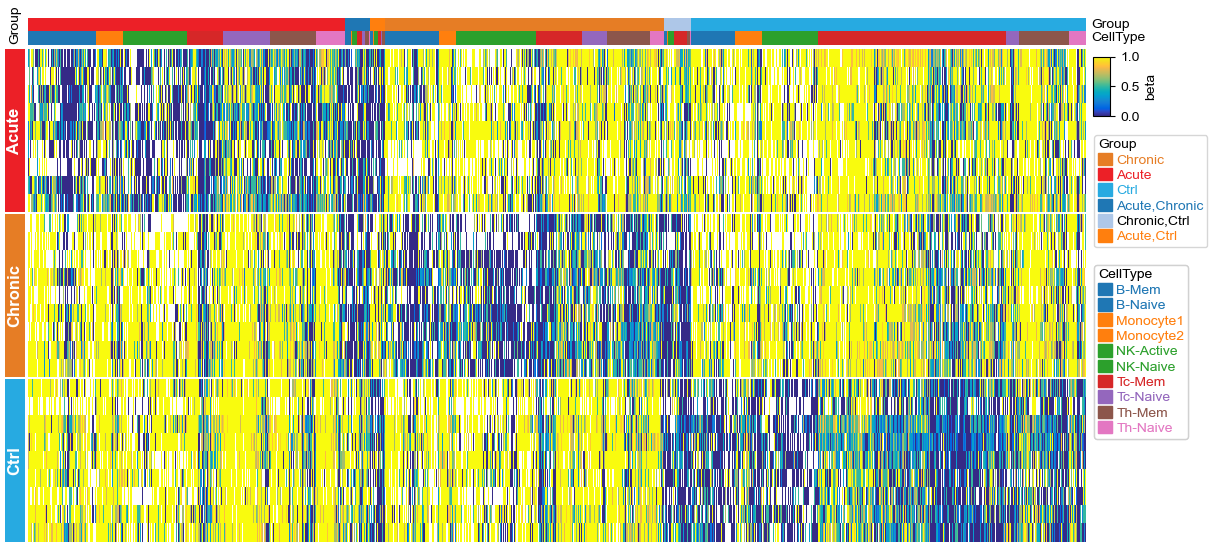

In [ ]:
sample_label_dict={'acu':'Acute','cro':'Chronic','pre':'Ctrl'}
ct_mapping={'NK-cell1':'NK-Active','NK-cell2': 'NK-Naive','Monocyte':'Monocyte1','Monocyte1':'Monocyte2'}
sample_group_color_dict={'Chronic':'#E67D25','Acute':'#EC2027','Ctrl':'#27AAE1'}

plot_heatmap(title="HIV",sample_label_dict=sample_label_dict,delta_beta_cutoff=delta_beta_cutoff,
            ct_mapping=ct_mapping,ct_color_dict=ct_color_dict,sep=',',
            sample_group_color_dict=sample_group_color_dict,row_split_order=['Acute','Chronic','Ctrl'])

['Ctrl,MSSA', 'MRSA,MSSA', 'Ctrl,MRSA']
(134867, 65)
   #chr    start      end celltype  MRSA_MRSA_0  MRSA_MRSA_11  MRSA_MRSA_13  \
0  chr1  1035803  1035803    B-Mem     0.666667      0.400000           NaN   
1  chr1  1055152  1055152    B-Mem     0.875000      0.000000           NaN   
2  chr1  1080343  1080343    B-Mem     0.000000      0.333333           NaN   
3  chr1  1229184  1229184    B-Mem     0.300000      0.200000           NaN   
4  chr1  1554290  1554290    B-Mem     0.666667      0.666667           NaN   

   MRSA_MRSA_15  MRSA_MRSA_20  MRSA_MRSA_21  ...  Ctrl_HIV_1  Ctrl_HIV_10  \
0           0.0           1.0      0.000000  ...         1.0          NaN   
1           NaN           NaN           NaN  ...         1.0          0.0   
2           NaN           NaN      0.666667  ...         NaN          NaN   
3           NaN           0.0      0.500000  ...         1.0          0.6   
4           NaN           1.0      0.000000  ...         1.0          NaN   

   Ctrl_H

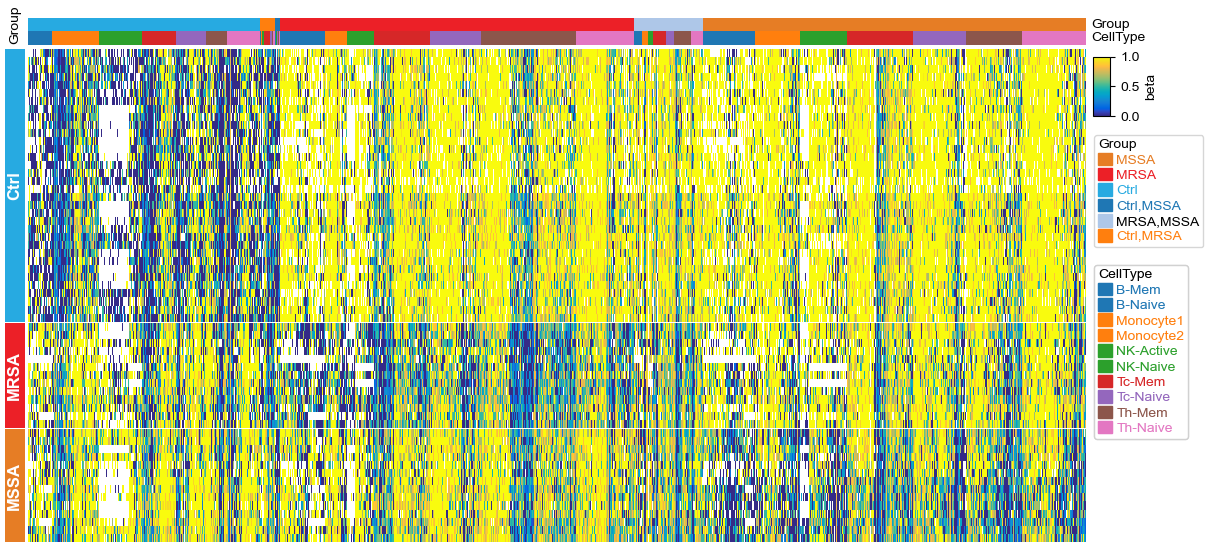

In [ ]:
sample_label_dict={'MRSA':'MRSA','MSSA':'MSSA','Ctrl':'Ctrl'}
ct_mapping={'NK-cell1':'NK-Active','NK-cell2': 'NK-Naive','Monocyte':'Monocyte1','Monocyte1':'Monocyte2'}
sample_group_color_dict={'MSSA':'#E67D25','MRSA':'#EC2027','Ctrl':'#27AAE1'}

plot_heatmap(title="MRSA",sample_label_dict=sample_label_dict,delta_beta_cutoff=delta_beta_cutoff,
            ct_mapping=ct_mapping,ct_color_dict=ct_color_dict,sep=',',
            sample_group_color_dict=sample_group_color_dict,row_split_order=['Ctrl','MRSA','MSSA'])

['H,M', 'H,L,M', 'H,L', 'L,M', 'Ctrl,L,M', 'Ctrl,M', 'Ctrl,L', 'Ctrl,H,L', 'Ctrl,H,M', 'Ctrl,H']
(198803, 65)
   #chr    start      end celltype  Low_OP_12  Low_OP_16  Low_OP_25  \
0  chr1   665098   665098    B-Mem      1.000   1.000000        NaN   
1  chr1  1097452  1097452    B-Mem      1.000   1.000000       1.00   
2  chr1  1182938  1182938    B-Mem      0.000   1.000000        NaN   
3  chr1  1378865  1378865    B-Mem      0.000   0.333333       0.00   
4  chr1  1381268  1381294    B-Mem      0.875   0.500000       0.75   

   Med_OP_15  Med_OP_19  Med_OP_2  ...  Ctrl_Flu_9  Ctrl_HIV_1  Ctrl_HIV_10  \
0        NaN   0.666667       NaN  ...         0.5         NaN          NaN   
1   0.666667   0.500000  0.000000  ...         1.0         1.0          1.0   
2   0.000000   0.000000  0.666667  ...         0.0         0.5          0.0   
3   0.750000        NaN  0.500000  ...         NaN         0.0          0.0   
4   0.500000   0.000000  0.444444  ...         0.0         0.0      

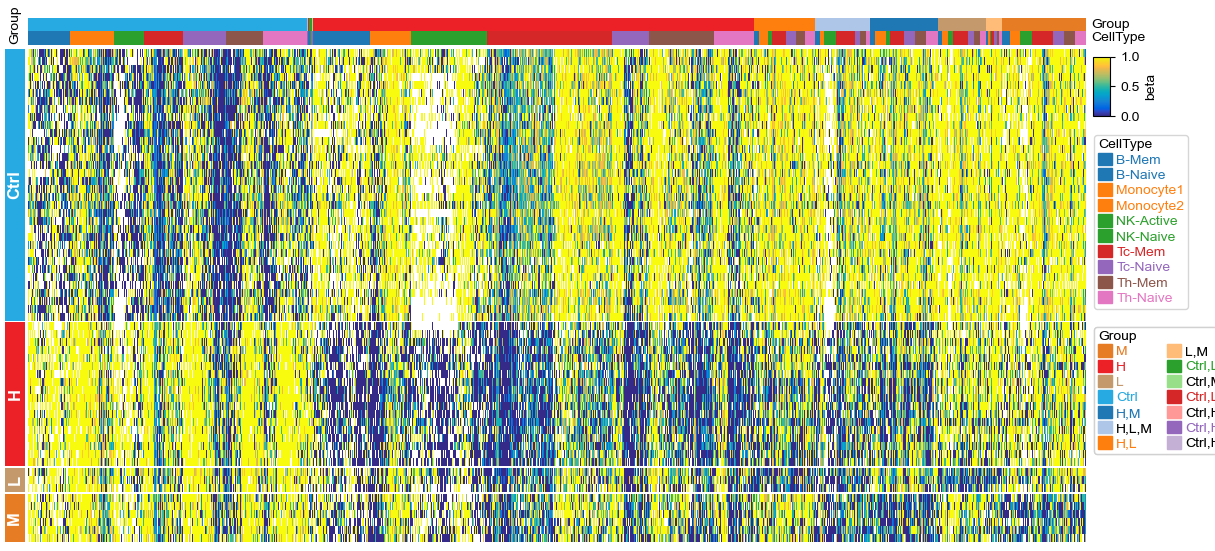

In [ ]:
sample_label_dict={'Low':'L','Med':'M','High':'H','Ctrl':'Ctrl'}
ct_mapping={'NK-cell1':'NK-Active','NK-cell2': 'NK-Naive','Monocyte':'Monocyte1','Monocyte1':'Monocyte2'}
sample_group_color_dict={'M':'#E67D25','H':'#EC2027','L':'#C49A6C','Ctrl':'#27AAE1'}

plot_heatmap(title="OP",sample_label_dict=sample_label_dict,delta_beta_cutoff=delta_beta_cutoff,
            ct_mapping=ct_mapping,ct_color_dict=ct_color_dict,
            sample_group_color_dict=sample_group_color_dict,row_split_order=['Ctrl','H','L','M'])